### Importing Essential Libraries

In [1]:
import nltk
# nltk.download("vader_lexicon")

import math
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

__Reading The Stock Price & News Headlines Data....__

In [2]:
# https://finance.yahoo.com/
stock_price = pd.read_csv("AAPL.csv")

# https://bit.ly/36fFPI6
news_headlines = pd.read_csv("india-news-headlines.csv")

In [3]:
stock_price.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.229537,452312000
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.252684,817073600
2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.263292,739396000


In [4]:
news_headlines.head(3)

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?


### Feature Engineering

In [5]:
print("Stock Price Data Shape: ", stock_price.shape[0], "×", stock_price.shape[1])
print("News Headlines Data Shape: ", news_headlines.shape[0], "×", news_headlines.shape[1])

Stock Price Data Shape:  4904 × 7
News Headlines Data Shape:  3424067 × 3


__Checking For Null Values....__

In [6]:
stock_price.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
news_headlines.isnull().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

__Cleaning Up The Stock Price Data....__

In [8]:
# Dropping duplicates
stock_price = stock_price.drop_duplicates()

# Coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price["Date"] = pd.to_datetime(stock_price["Date"])

# Filtering the important columns required
stock_price = stock_price.filter(["Date", "Close", "Open", "High", "Low", "Volume"])

# Setting column 'Date' as the index column
stock_price.set_index("Date", inplace = True)

# Sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending = True, axis = 0)
stock_price.head(3)

,Close,Open,High,Low,Volume
Date,,,,,
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000


__Cleaning Up The News Headlines Data....__

In [9]:
# Dropping duplicates
news_headlines = news_headlines.drop_duplicates()

# Coverting the datatype of column 'Date' from type object to type 'datetime'
news_headlines["publish_date"] = news_headlines["publish_date"].astype(str)
news_headlines["publish_date"] = news_headlines["publish_date"].apply(lambda x: x[0:4] + '-' + x[4:6] + '-' + x[6:8])
news_headlines["publish_date"] = pd.to_datetime(news_headlines["publish_date"])

# Filtering the important columns required
news_headlines = news_headlines.filter(["publish_date", "headline_text"])

# Grouping the news headlines according to 'Date'
news_headlines = news_headlines.groupby(["publish_date"])["headline_text"].apply(lambda x: ','.join(x)).reset_index()

# Setting column 'Date' as the index column
news_headlines.set_index("publish_date", inplace= True)

# Sorting the data according to the index i.e 'Date'
news_headlines = news_headlines.sort_index(ascending=True, axis=0)
news_headlines.head(3)

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...


__Merging Stock Price And News Headlines Data....__

In [10]:
stock_data = pd.concat([stock_price, news_headlines], axis = 1)
stock_data.dropna(axis = 0, inplace = True)
stock_data.head(3)

,Close,Open,High,Low,Volume,headline_text
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000.0,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600.0,"Powerless north India gropes in the dark,Think..."
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000.0,The string that pulled Stephen Hawking to Indi...


### Calculating Sentiment / Polarity Scores

* Positive
* Negative
* Neutral
* Compound

The compound score is the sum of positive, negative & neutral scores which is then normalized between -1 (most extreme negative) and +1 (most extreme positive).

The more Compound score closer to +1, the higher the positivity of the text.

In [11]:
# Adding empty sentiment columns to stock_data for later calculation
stock_data["Positive"] = ""
stock_data["Negative"] = ""
stock_data["Neutral"] = ""
stock_data["Compound"] = ""

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

SIA = SentimentIntensityAnalyzer()

# Calculating sentiment scores
stock_data["Compound"] = stock_data["headline_text"].apply(lambda x: SIA.polarity_scores(x)["compound"])
stock_data["Negative"] = stock_data["headline_text"].apply(lambda x: SIA.polarity_scores(x)["neg"])
stock_data["Neutral"] = stock_data["headline_text"].apply(lambda x: SIA.polarity_scores(x)["neu"])
stock_data["Positive"] = stock_data["headline_text"].apply(lambda x: SIA.polarity_scores(x)["pos"])

# Dropping the 'headline_text' which is unwanted now
stock_data.drop(["headline_text"], inplace = True, axis = 1)

# Rearranging the columns of the whole stock_data
stock_data = stock_data[["Close", "Compound", "Negative", "Neutral", "Positive", "Open", "High", "Low", "Volume"]]
stock_data.head(3)

,Close,Compound,Negative,Neutral,Positive,Open,High,Low,Volume
2001-01-02,0.265625,-0.9621,0.119,0.817,0.064,0.265625,0.272321,0.260045,452312000.0
2001-01-03,0.292411,0.6322,0.084,0.817,0.098,0.258929,0.297991,0.257813,817073600.0
2001-01-04,0.304688,0.6648,0.077,0.843,0.080,0.323940,0.330357,0.300223,739396000.0


__Writing The Prepared Stock Data To The Disk....__

In [13]:
stock_data.to_csv("stock_data.csv")

### Re - Reading The Stock Data & Feature Engineering

In [14]:
stock_data = pd.read_csv("stock_data.csv", index_col = False)

# Renaming the column
stock_data.rename(columns = {"Unnamed: 0":"Date"}, inplace = True)

# Setting the column 'Date' as the index column
stock_data.set_index("Date", inplace = True)
stock_data.head(3)

,Close,Compound,Negative,Neutral,Positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,0.265625,-0.9621,0.119,0.817,0.064,0.265625,0.272321,0.260045,452312000.0
2001-01-03,0.292411,0.6322,0.084,0.817,0.098,0.258929,0.297991,0.257813,817073600.0
2001-01-04,0.304688,0.6648,0.077,0.843,0.080,0.323940,0.330357,0.300223,739396000.0


In [15]:
print("Stock Data Shape: ", stock_data.shape[0], "×", stock_data.shape[1])

Stock Data Shape:  4876 × 9


__Checking For Null Values....__

In [16]:
stock_data.isnull().sum()

Close       0
Compound    0
Negative    0
Neutral     0
Positive    0
Open        0
High        0
Low         0
Volume      0
dtype: int64

__Stock Data Statistics....__

In [17]:
stock_data.describe(include = "all")

,Close,Compound,Negative,Neutral,Positive,Open,High,Low,Volume
count,4876.000000,4876.000000,4876.000000,4876.000000,4876.000000,4876.000000,4876.000000,4876.000000,4.876000e+03
mean,17.240855,-0.867993,0.126606,0.786317,0.087070,17.231561,17.406451,17.060156,4.512664e+08
std,18.701517,0.457759,0.024253,0.033011,0.020944,18.671171,18.873885,18.500307,3.855541e+08
min,0.234286,-1.000000,0.000000,0.000000,0.000000,0.231964,0.235536,0.227143,3.247000e+07
25%,2.134196,-0.999800,0.113000,0.766000,0.076000,2.137232,2.173392,2.097143,1.774491e+08
50%,10.928036,-0.999100,0.128000,0.782000,0.087000,10.909285,11.007143,10.769642,3.374560e+08
75%,27.350625,-0.994200,0.142000,0.804000,0.097000,27.336249,27.606875,27.106250,6.050912e+08
max,91.632500,1.000000,0.444000,1.000000,0.608000,91.250000,93.095001,90.567497,3.372970e+09


In [18]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4876 entries, 2001-01-02 to 2020-06-30
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     4876 non-null   float64
 1   Compound  4876 non-null   float64
 2   Negative  4876 non-null   float64
 3   Neutral   4876 non-null   float64
 4   Positive  4876 non-null   float64
 5   Open      4876 non-null   float64
 6   High      4876 non-null   float64
 7   Low       4876 non-null   float64
 8   Volume    4876 non-null   float64
dtypes: float64(9)
memory usage: 380.9+ KB


### EDA On Stock Data

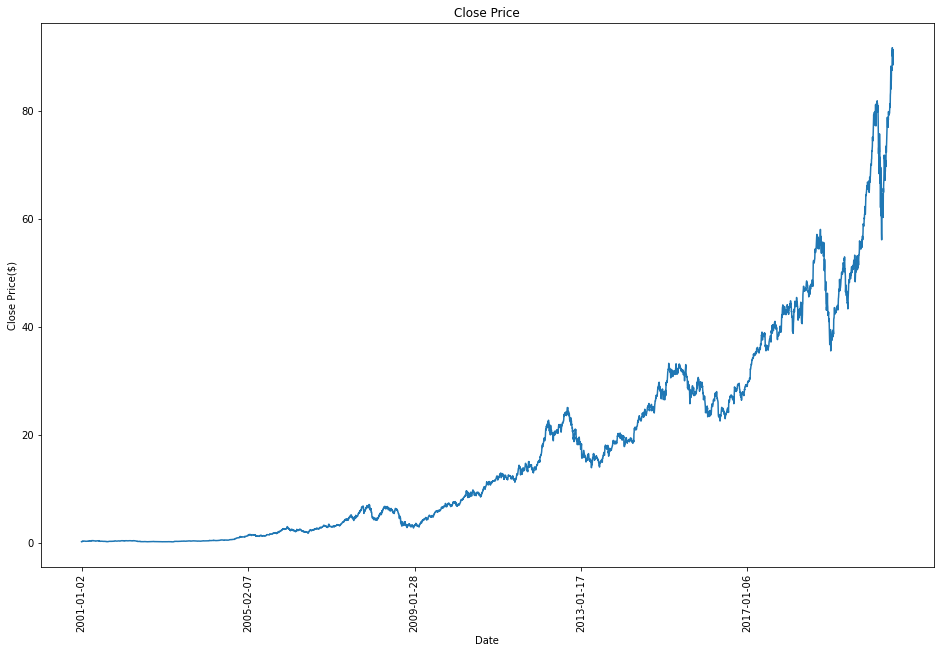

In [19]:
plt.figure(figsize = (16, 10))
ax = sns.lineplot(x = stock_data.index, y = stock_data["Close"])
ax.set_xticks(ax.get_xticks()[::1000])
plt.xlabel("Date")
plt.ylabel("Close Price($)")
plt.xticks(rotation = 90)
plt.title("Close Price")
plt.show()

__Correlation Map....__

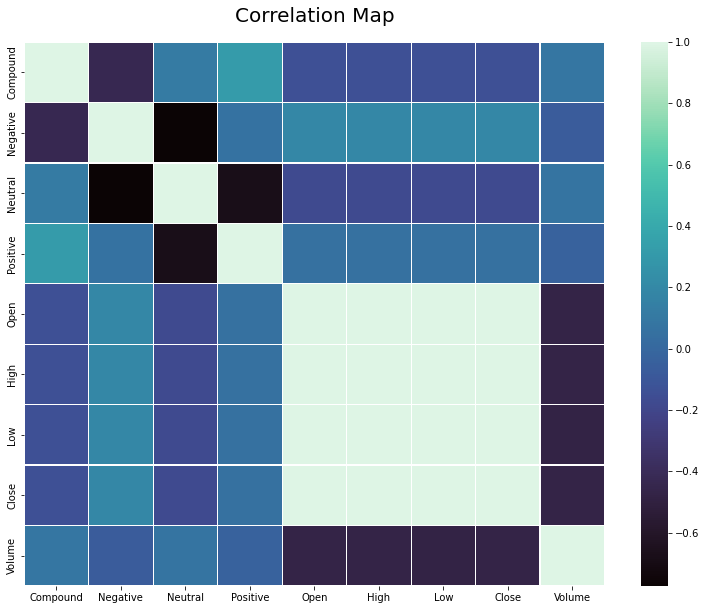

In [20]:
plt.figure(figsize = (13, 10))
sns.heatmap(
    stock_data[['Compound', 'Negative', 'Neutral', 'Positive', 'Open', 'High',
       'Low', 'Close', 'Volume']].corr(),
    linewidths = .1, 
    cmap = sns.color_palette("mako", as_cmap=True), 
)
plt.title(
    "Correlation Map",
    fontsize = 20,
    pad = 20
)
plt.xlabel("")
plt.ylabel("")
plt.show()

__Calculating 7 Day Rolling Mean....__

In [21]:
stock_data.rolling(7).mean().head(10)

,Close,Compound,Negative,Neutral,Positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-10,0.293368,-0.175914,0.121571,0.810143,0.068000,0.293088,0.304687,0.281728,566364000.0
2001-01-23,0.307717,0.094314,0.109714,0.818286,0.071714,0.304408,0.319196,0.293208,627395200.0
2001-01-24,0.318240,-0.125129,0.111429,0.825000,0.063429,0.320033,0.329400,0.306282,613112000.0


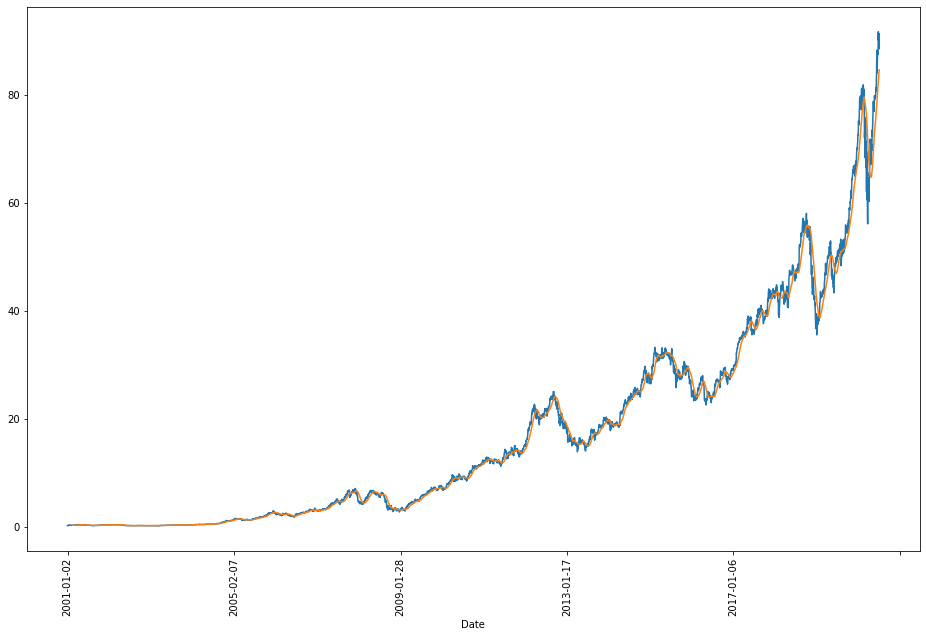

In [22]:
# Plotting the close price and a 30-day rolling mean of close price
plt.figure(figsize = (16, 10))
stock_data["Close"].plot()
stock_data.rolling(window = 30).mean()["Close"].plot()
plt.xticks(rotation = 90)
plt.show()

### Data Preparation For Model Creation

In [23]:
time_step = 1
training_size = int(len(stock_data) * 0.80)
test_size = len(stock_data) - training_size
train_data, test_data = stock_data.iloc[0:training_size, :], stock_data.iloc[training_size - time_step:len(stock_data), :]

In [24]:
def create_dataset(data, time_step = 1):
    features = [data["Close"]]
    feature_names = ["Close"]
    for i in range(1, time_step + 1):
        feature = "cp_shifted_{k}".format(k = i)
        feature_names.append(feature)
        temp = data["Close"].shift((-1 * i))
        features.append(temp);
        
    features.append(data["Compound"]) 
    feature_names.append("Compound")
    for i in range(1, time_step + 1):
        feature = "compound_shifted_{k}".format(k = i)
        feature_names.append(feature)
        temp = data["Compound"].shift((-1 * i))
        features.append(temp);
    
    
    df = pd.concat(features, axis=1)
    df.columns = feature_names
    df = df.shift(periods = time_step)
    df = df.dropna()
    return df
    

In [25]:
X_train = create_dataset(train_data, time_step)
X_test = create_dataset(test_data, time_step)

In [26]:
y_train = X_train["cp_shifted_{t}".format(t = time_step)]
y_test = X_test["cp_shifted_{t}".format(t = time_step)]

In [27]:
X_train.drop(columns = ["cp_shifted_{t}".format(t = time_step)], inplace = True)
X_test.drop(columns = ["cp_shifted_{t}".format(t = time_step)], inplace = True)

In [28]:
X_train.shape, X_test.shape

((3899, 3), (976, 3))

### Scaling The Target Variable And The Feature Dataset            

LSTM can be very sensitive to the scale of the data, So Here I am using MinMaxScaler to scale each input variable separately to the range 0-1.

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

X_train = scaler.fit_transform(np.array(X_train))
y_train = scaler.fit_transform(np.array(y_train).reshape((len(y_train), 1)))

X_test = scaler.fit_transform(np.array(X_test))
y_test = scaler.fit_transform(np.array(y_test).reshape((len(y_test), 1)))

In [30]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3899, 3), (3899, 1), (976, 3), (976, 1))

### Dividing The Dataset Into Training And Test

Since our data is time-series data we cannot simply use train_test_split to split the data, So here I am creating train and test data separately without using train_test_split. 

In [31]:
# Reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# Printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (3899, 3, 1)
Shape of Test set X: (976, 3, 1)


### Stock Data Modelling

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation

In [33]:
# Creating the model architecture
model=Sequential()
model.add(LSTM(60,return_sequences=True,activation='tanh',input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(120,return_sequences=True,activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(240,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# Printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 60)             14880     
_________________________________________________________________
dropout (Dropout)            (None, 3, 60)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 120)            86880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 120)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 240)               346560    
_________________________________________________________________
dropout_2 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [34]:
# Compiling the model
model.compile(loss='mse' , optimizer='adam')

# Fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=25, batch_size=16, verbose=1)

Epoch 1/25
195/195 [==============================] - 2s 11ms/step - loss: 0.0092 - val_loss: 9.5260e-04
Epoch 2/25
195/195 [==============================] - 1s 7ms/step - loss: 9.2032e-04 - val_loss: 3.4838e-04
Epoch 3/25
195/195 [==============================] - 1s 7ms/step - loss: 7.4414e-04 - val_loss: 0.0021
Epoch 4/25
195/195 [==============================] - 1s 7ms/step - loss: 6.8584e-04 - val_loss: 0.0025
Epoch 5/25
195/195 [==============================] - 1s 7ms/step - loss: 5.4872e-04 - val_loss: 0.0110
Epoch 6/25
195/195 [==============================] - 1s 7ms/step - loss: 6.6350e-04 - val_loss: 0.0028
Epoch 7/25
195/195 [==============================] - 1s 7ms/step - loss: 5.3655e-04 - val_loss: 4.5106e-04
Epoch 8/25
195/195 [==============================] - 1s 7ms/step - loss: 4.5022e-04 - val_loss: 3.4690e-04
Epoch 9/25
195/195 [==============================] - 1s 7ms/step - loss: 4.9186e-04 - val_loss: 0.0016
Epoch 10/25
195/195 [==============================

## Saving The Model To disk

In [35]:
# Saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# Serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


## Predictions

In [36]:
predictions = model.predict(X_test) 

# Unscaling the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# Printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[27.43532 ],
       [27.738869],
       [27.804941],
       [27.682446],
       [27.650007]], dtype=float32)

In [37]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [38]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [39]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

47.22572740023225

In [40]:
math.sqrt(mean_squared_error(y_test,test_predict))

48.85056165248737

## Model Evaluation

In [41]:
# Calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# Calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# Printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

976/976 [==============================] - 1s 1ms/step - loss: 6.1870e-04
Train Loss = 0.0007
Test Loss = 0.0006


In [44]:
from sklearn import metrics

In [45]:
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 48.8506


In [46]:
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 48.8506


## Plotting The Predictions Against Unseen Data

In [47]:
X_test = scaler.inverse_transform(np.array(X_test).reshape((len(X_test), 3)))

# Unscaling y_test, y_train
y_train = scaler.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

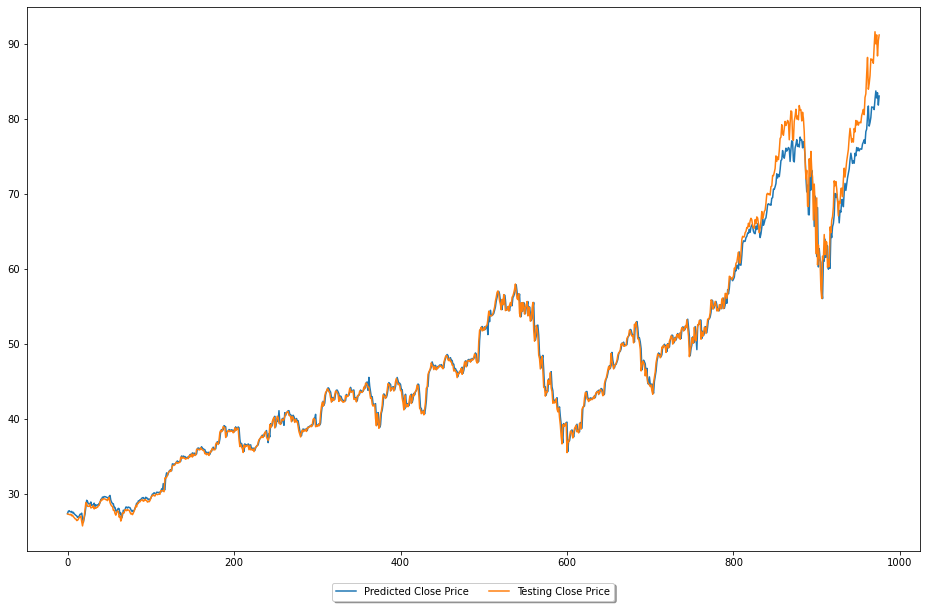

In [48]:
# Plotting
plt.figure(figsize=(16,10))

plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()